<a href="https://colab.research.google.com/github/raymanzi/blogBackendRay/blob/master/ClassificationOnPastis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2 Basic of validation: accuracy, precision and recall [20 points]


In [ ]:
import os
import numpy as np
from glob import glob
import sklearn
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [104]:
class PASTISSegmentation:
    """
    Here we use a subset of the PASTIS dataset: https://github.com/VSainteuf/pastis-benchmark
    """
    def __init__(
        self,
        image_dir: str,
        annotation_dir: str,
        split: str = "train",
        median_of_days: bool = False,
        binary_labels: bool = False
    ) -> None:
        images = glob(os.path.join(image_dir, split, 'S2_*.npy'))
        annotations = []
        for im in images:
            name = os.path.splitext(os.path.basename(im))[0].replace("S2_", "")
            annotations.append(os.path.join(annotation_dir, split, f"TARGET_{name}.npy"))

        self.median_of_days = median_of_days
        self.binary_labels = binary_labels

        self.X = self.read_data(images)
        if median_of_days:
            self.X = np.median(self.X, axis=1)  # Take median value across 43 days

        self.y = self.read_data(annotations)
        self.y = self.y[:, 0]  # We are only interested in the 20 classes for now
        if binary_labels:
            self.y[self.y > 0] = 1  # Convert to binary labels

    def __len__(self):
        return self.X.shape[0]

    def read_data(self, files):
        """
        Reads and stacks our data
        """
        t = []
        for im in files:
            t.append(np.load(im))
        return np.stack(t, axis=0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def pixelwise(self):
        """
        This method flattens our images to individual pixels, so we can treat
        each pixel as a sample and train our favorite classifier on it.
        """
        if self.median_of_days:
            return np.transpose(self.X, (0, 2, 3, 1)).reshape(-1, 10), self.y.reshape(-1)
        else:
            return np.transpose(self.X, (0, 3, 4, 1, 2)).reshape(-1, 430), self.y.reshape(-1)

    def pixelwise_test(self):
        """
        Short test for the above method.
        """
        N = self.__len__()

        pX, py = self.pixelwise()
        if self.median_of_days:
            tX = np.transpose(pX.reshape(N, 128, 128, 10), (0, 3, 1, 2))
        else:
            tX = np.transpose(pX.reshape(N, 128, 128, 43, 10), (0, 3, 4, 1, 2))
        tY = py.reshape(N, 128, 128)
        assert np.all(tX == self.X) and np.all(tY == self.y)
        print("All test passed!")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/data

annotations  confusion_matrix.png  images


In [105]:
base_path = '/content/drive/MyDrive/data' # You may need to redefine this variable. ".." refers to the parent folder of the present working directory.
images = os.path.join(base_path, "images/")
annotations = os.path.join(base_path, "annotations/")
p_train = PASTISSegmentation(images, annotations, split="train", median_of_days=False, binary_labels=False)
p_val = PASTISSegmentation(images, annotations, split="val", median_of_days=False, binary_labels=False)
p_test = PASTISSegmentation(images, annotations, split="test", median_of_days=False, binary_labels=False)


X_train, y_train = p_train.pixelwise()
X_val, y_val = p_test.pixelwise()
X_test, y_test = p_test.pixelwise()

In [ ]:
# Instead of images, we focus on the individual pixels. For each pixel, we have 10 features and a class (in y).
X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((245760, 430), (245760,), (81920, 430), (81920,))

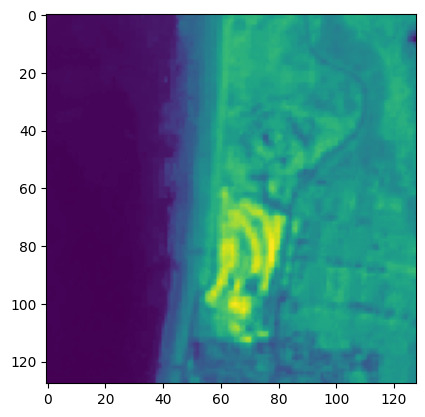

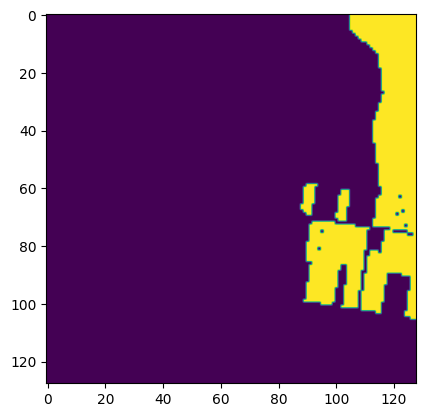

In [ ]:
imd = 1
# Show the 7th band of the second image
plt.imshow(p_train.X[imd, 6])
plt.show()

# Show the labels for second image
plt.imshow(p_train.y[imd])
plt.show()

# Binary Classification

In [ ]:
# Train a KNeighborsClassifier
classifier = KNeighborsClassifier().fit(X_train, y_train)


In [ ]:
def get_positive_class_probabilities(clf, data):
    pb = clf.predict_proba(data)
    assert pb.shape[1] == 2, "The classifier predicts more than 2 classes."
    return pb[:,1]


In [ ]:
''' In classification tasks, the output layer of a neural network typically produces
predictions in the form of class probabilities or scores. These predictions are often
represented as a vector, with each element corresponding to the probability or score of
a particular class. This vector can be considered as a flattened representation of the output.'''
y_pred_prob = get_positive_class_probabilities(classifier, X_test)

Input image - band 7


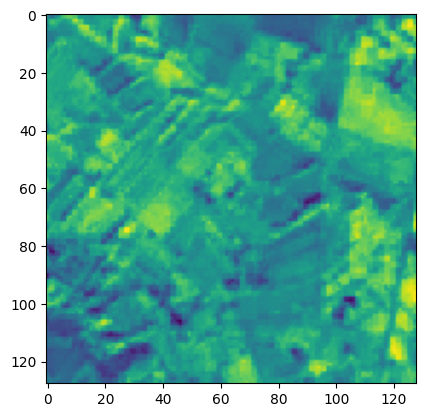

Expert labels/Ground truth/y_test


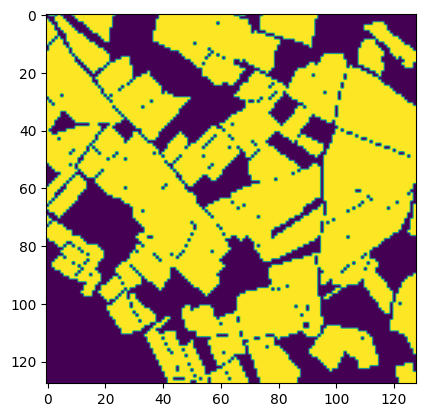

Predicted probabilities


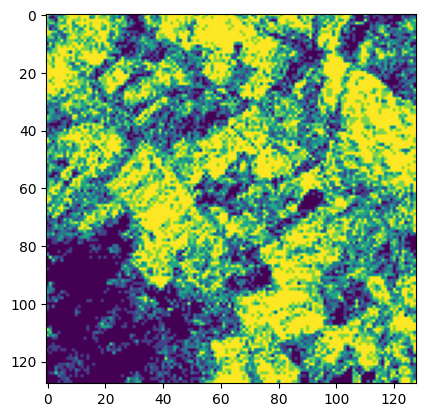

Predicted classes at threshold of 0.5


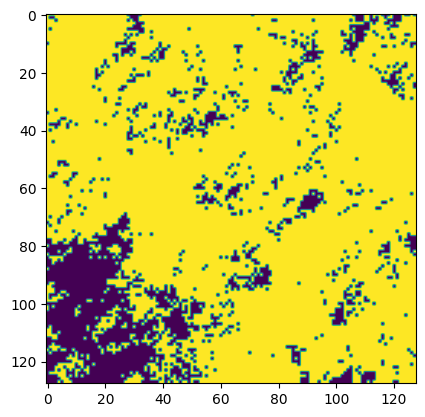

In [ ]:
# Show prediction for one image
print("Input image - band 7")
plt.imshow(p_test.X[imd, 6])
plt.show()

# Binarize using a threshold of 0.5
print("Expert labels/Ground truth/y_test")
yb = y_test.reshape(-1, 128, 128)
plt.imshow(yb[imd])
plt.show()

tpb = y_pred_prob.copy().reshape(-1, 128, 128)
print("Predicted probabilities")
plt.imshow(tpb[imd])
plt.show()

# Binarize using a threshold of 0.5
print("Predicted classes at threshold of 0.5")
tpb[tpb >= 0.1] = 1
tpb[tpb < 0.1] = 0
plt.imshow(tpb[imd])
plt.show()



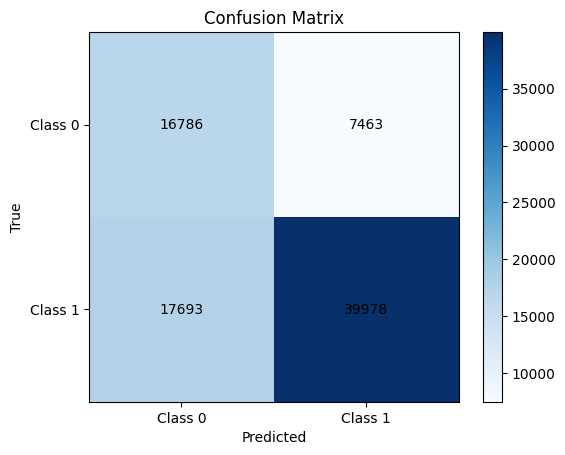

In [ ]:
# Task 2a: Plot the confusion matrix of the given method at a probability cutoff of 0.5
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def compute_confusion_matrix(y_pred_prob, y_test, cutoff=0.5):
    y_pred = (y_pred_prob >= cutoff).astype(int)  # Getting predictions
    cm = confusion_matrix(y_test, y_pred)
    return cm

def plot_confusion_matrix(cm):
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0, 1], ['Class 0', 'Class 1'])
    plt.yticks([0, 1], ['Class 0', 'Class 1'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')
            plt.savefig('/content/drive/MyDrive/data/confusion_matrix.png')  # Save the plot as a PNG image
    plt.show()

cm = compute_confusion_matrix(y_pred_prob, y_test, cutoff=0.5)
plot_confusion_matrix(cm)




In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def compute_confusion_matrix(y_pred_prob, y_test, cutoff=0.5):
    y_pred = (y_pred_prob >= cutoff).astype(int)  # Getting predictions
    cm = confusion_matrix(y_test, y_pred)
    return cm

def print_confusion_matrix(cm):
    true_positives = cm[1, 1]
    false_positives = cm[0, 1]
    true_negatives = cm[0, 0]
    false_negatives = cm[1, 0]

    print(f"True Positives: {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"True Negatives: {true_negatives}")
    print(f"False Negatives: {false_negatives}")

def plot_confusion_matrix(cm):
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0, 1], ['Class 0', 'Class 1'])
    plt.yticks([0, 1], ['Class 0', 'Class 1'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')
    plt.show()

cm = compute_confusion_matrix(y_pred_prob, y_test, cutoff=0.5)
print_confusion_matrix(cm)
# plot_confusion_matrix(cm)


True Positives: 39978
False Positives: 7463
True Negatives: 16786
False Negatives: 17693


In [ ]:
# Task 2b-2d Accuracy, precision and recall

''' y_pred_prob: Predicted probabilities of the positive class for each instance.
    y_test: True labels for each instance.
    cutoff: Threshold for converting probabilities to binary predictions (default is 0.5).
'''

def accuracy(y_pred_prob, y_test, cutoff=0.5):
    y_pred = (y_pred_prob >= cutoff).astype(int)  # Convert probabilities to binary predictions
    correct_predictions = (y_pred == y_test).sum()  # Count correct predictions
    total_predictions = len(y_test)  # Total number of predictions
    accuracy = correct_predictions / total_predictions  # Calculate accuracy
    return accuracy

acc = accuracy(y_pred_prob, y_test)
print("Accuracy:", acc)

# Precision = TP / (TP + FP)
def compute_precision(cm):
    true_positives = cm[1, 1]
    false_positives = cm[0, 1]
    precision = true_positives / (true_positives + false_positives)
    return precision

precision = compute_precision(cm)
print("Precision at cutoff 0.5:", precision)

# Recall = TP/(TP+FN)
def recall_score(cm):
  recall= cm[1,1]/(cm[1,1]+cm[1,0])
  return recall

recall_var = recall_score(cm)
print ("the recall score at the cutoff of 0.5 is equal to: ", recall_var)

def IntersectionOverUnion(cm):
  IoU = cm[1,1]/(cm[1,1]+cm[0,1]+cm[1,0])
  return IoU

JaccardCoefficient = IntersectionOverUnion(cm)
print("the IoU ay 0.5 is: ",JaccardCoefficient)


Accuracy: 0.692919921875
Precision at cutoff 0.5: 0.8426888134735777
the recall score at the cutoff of 0.5 is equal to:  0.693208024830504
the IoU ay 0.5 is:  0.6137808210765499


In [ ]:
# What is the accuracy, precision and recall of the given method at a probability cutoff of 0.5?
# What is the accuracy, precision and recall of the given method at a probability cutoff of 0.3?
def accuracy(y_pred_prob, y_test, cutoff= 0.01):
  y_pred=(y_pred_prob>=cutoff).astype(int)
  correct_predictions=(y_pred==y_test).sum()
  total_predictions=(len(y_test))
  accuracy= correct_predictions/total_predictions

  return accuracy

acc = accuracy (y_pred_prob, y_test)
print("accuracy:", acc)

def precision_calculation (cm):
  precision= cm[1,1]/cm[1,1]+cm[0,1]
  return precision

precision_var = precision_calculation(cm)
print("this is the precision at 0.3: ", precision_var)

def recall_score(cm):
  recall= cm[1,1]/(cm[1,1]+cm[1,0])
  return recall

recall_var = recall_score(cm)
print ("the recall score at the cutoff of 0.5 is equal to: ", recall_var)


accuracy: 0.75047607421875
this is the precision at 0.3:  7464.0
the recall score at the cutoff of 0.5 is equal to:  0.693208024830504


In [ ]:
# What is the accuracy, precision and recall of the given method at a probability cutoff of 0.8?
def accuracy(y_pred_prob, y_test, cutoff= 0.8):
  y_pred =(y_pred_prob>=cutoff).astype(int)
  correct_predictions = (y_pred==y_test).sum()
  total_predictions= len(y_test)
  accuracy= correct_predictions/total_predictions
  return accuracy

acc = accuracy (y_pred_prob, y_test)
print("accurecy:", acc)

def precision_calculation (cm):
  precision = cm[1,1]/cm[1,1]+cm[0,1]
  return precision

precis = precision_calculation(cm)
print("this is the precision at the cutoff of 0.8", precis)


def recall_score(cm):
  recall= cm[1,1]/(cm[1,1]+cm[1,0])
  return recall

recall_var = recall_score(cm)
print ("the recall score at the cutoff of 0.5 is equal to: ", recall_var)

accurecy: 0.61519775390625
this is the precision at the cutoff of 0.8 7464.0
the recall score at the cutoff of 0.5 is equal to:  0.693208024830504


In [ ]:
# What is the accuracy, precision and recall of the given method at probability cutoff of 0.01?
def accuracy (y_pred_prob, y_test, cutoff= 0.01):
  y_pred= (y_pred_prob>=cutoff).astype(int)
  correct_predictions=(y_pred==y_test).sum()
  total_predictions= len(y_test)
  accuracy = correct_predictions/total_predictions

  return accuracy

acc= accuracy(y_pred_prob, y_test)
print("the acuuracy is:", acc)

def precision_calculation (cm):
  precision = cm[1,1]/cm[1,1]+cm[0,1]
  return precision

precis = precision_calculation(cm)
print("precision at 0.01: ", precis)

def recall_score(cm):
  recall= cm[1,1]/(cm[1,1]+cm[1,0])
  return recall

recall_var = recall_score(cm)
print ("the recall score at the cutoff of 0.5 is equal to: ", recall_var)


the acuuracy is: 0.75047607421875
precision at 0.01:  7464.0
the recall score at the cutoff of 0.5 is equal to:  0.693208024830504


In [ ]:
from sklearn.metrics import log_loss
# Binary cross-entropy measures the difference between the predicted probabilities and the true labels.
# y_pred_prob is the predicted probabilities and y_test is the true labels
binary_cross_entropy = log_loss(y_test, y_pred_prob)
print("Binary Cross-Entropy:", binary_cross_entropy)


Binary Cross-Entropy: 3.08315255838299


# Task 3 Preparing your own dataset [30 points]


In [ ]:
! pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 32.8 MB/s eta 0:00:00


In [ ]:
! ls drive/MyDrive/Sentinel2_France_10bands.tif



drive/MyDrive/Sentinel2_France_10bands.tif


In [ ]:
# Function to load imgs from a TIFF file
import rasterio
def load_sentinel_image_tiff(file_path):
    with rasterio.open(file_path) as src:
        image = src.read([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # Reading the 10 bands
        image = np.transpose(image, (1, 2, 0))  # Transpose to (h, w, c), channel last
    return image

france_image = load_sentinel_image_tiff('/content/drive/MyDrive/Sentinel2_France_10bands.tif')
egypt_image = load_sentinel_image_tiff('/content/drive/MyDrive/Sentinel2_Egypt_10bands.tif')

# Process and reshape the img to match required input format
def preprocess_image(image):
    height, width, bands = image.shape
    return image.reshape(-1, bands)

X_france = preprocess_image(france_image)
X_egypt = preprocess_image(egypt_image)


In [ ]:
# `classifier` is already trained above
y_pred_prob_france = get_positive_class_probabilities(classifier, X_france)
y_pred_prob_egypt = get_positive_class_probabilities(classifier, X_egypt)

# Adjust `y_test` to have the same number of samples as the predictions
y_test_france = np.random.randint(0, 2, size=y_pred_prob_france.shape[0])
y_test_egypt = np.random.randint(0, 2, size=y_pred_prob_egypt.shape[0])


In [ ]:
import matplotlib.pyplot as plt

# Function to plot individual bands of img
def plot_band(image, band_index, title):
    plt.imshow(image[:, :, band_index], cmap='viridis')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plotting individual bands of the original img
for i in range(1, 11):
    plot_band(france_image, i, f'Band {i} of Sentinel-2 Image for France')

for i in range(1, 11):
    plot_band(egypt_image, i, f'Band {i} of Sentinel-2 Image for Egypt')


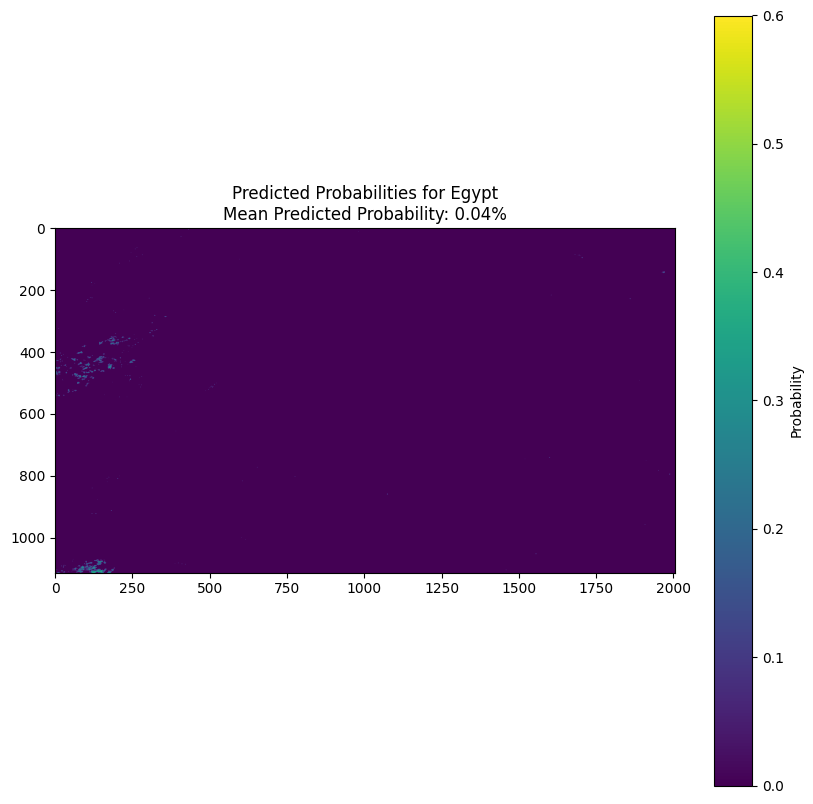

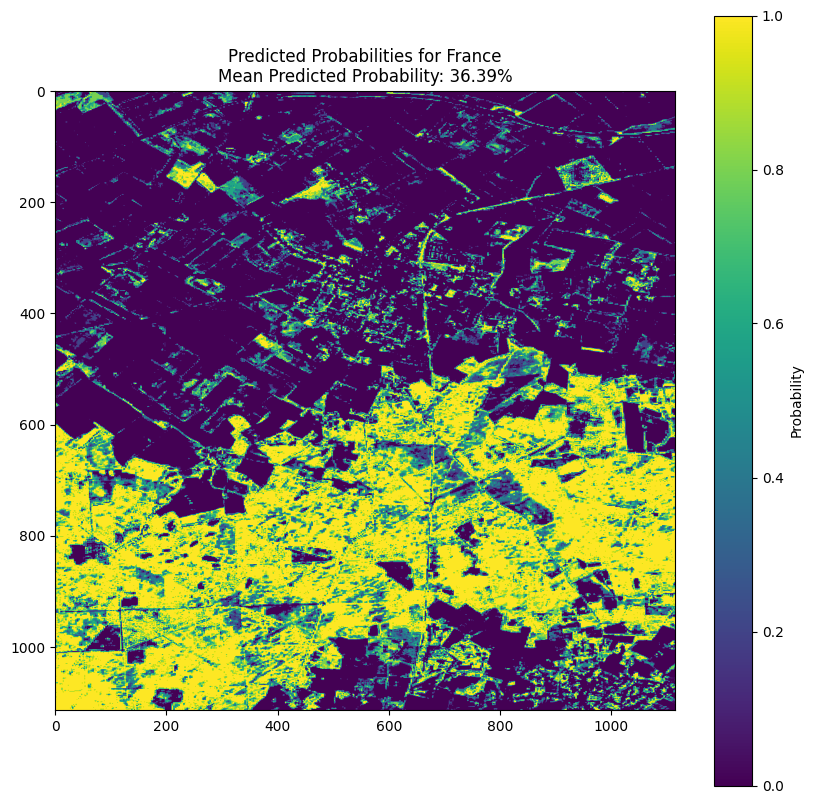

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Function to plot predicted probabilities and save as PNG
def plot_predicted_probabilities(pred_prob, title, image_shape, save_path):
    prob_reshaped = pred_prob.reshape(image_shape[:2])
    plt.figure(figsize=(10, 10))
    plt.imshow(prob_reshaped, cmap='viridis')
    plt.colorbar(label='Probability')

    # Calculate the mean predicted probability percentage
    mean_prob = np.mean(pred_prob) * 100
    plt.title(f'{title}\nMean Predicted Probability: {mean_prob:.2f}%')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Save plt as png
    plt.show()

plot_predicted_probabilities(y_pred_prob_egypt, 'Predicted Probabilities for Egypt', egypt_image.shape, '/content/drive/MyDrive/Egypt.png')

plot_predicted_probabilities(y_pred_prob_france, 'Predicted Probabilities for France', france_image.shape, '/content/drive/MyDrive/France.png')


In [ ]:
# Compute cm for France and Egypt
def compute_confusion_matrix(y_pred_prob, y_test, cutoff=0.5):
    y_pred = (y_pred_prob >= cutoff).astype(int)  # Getting predictions
    cm = confusion_matrix(y_test, y_pred)
    return cm


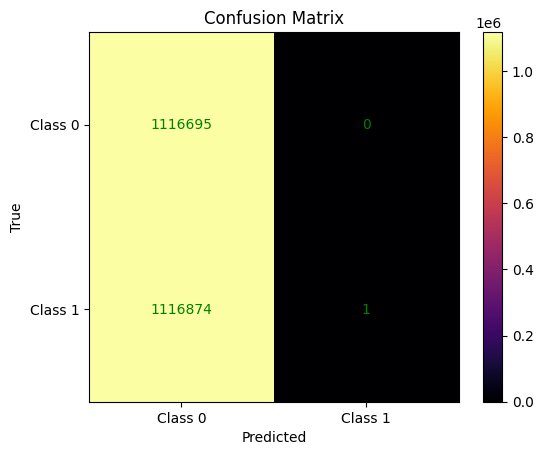

Confusion Matrix for Egypt Image: [[1116695       0]
 [1116874       1]]


In [ ]:
# the confusion matrix
def plot_confusion_matrix(cm, colormap='tab10'):
    plt.imshow(cm, cmap=colormap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0, 1], ['Class 0', 'Class 1'])
    plt.yticks([0, 1], ['Class 0', 'Class 1'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='green')
    plt.savefig('/content/drive/MyDrive/data/confusion_matrix.png')
    plt.show()

# Compute confusion matrices

cm_egypt = compute_confusion_matrix(y_pred_prob_egypt, y_test_egypt)

plot_confusion_matrix(cm_egypt, colormap='inferno')

print("Confusion Matrix for Egypt Image:", cm_egypt)

# Task 4 Logistic Regression [20 points]

In [ ]:
# TODO: Define the logistic classifier and fit it on the training set (X_train, y_train)
# Hint: If using sklearn set n_jobs=-1 for parallezing the model fit
logistic_regressor = ??


SyntaxError: invalid syntax (<ipython-input-33-2a8c0f598115>, line 3)

In [106]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the logistic classifier and fit it on the training set (X_train, y_train)
log_reg = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
log_reg.fit(X_train, y_train)

# Predict on validation data
y_pred_val = log_reg.predict(X_val)


In [107]:
# Get the actual classes present in the validation and test sets
actual_classes_val = np.unique(y_val)
actual_classes_test = np.unique(y_test)

# Calculate accuracy, recall, and precision on validation data
accuracy_val = accuracy_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val, average='macro', zero_division=0)
precision_val = precision_score(y_val, y_pred_val, average='macro', zero_division=0)
report_val = classification_report(y_val, y_pred_val, target_names=[f'Class {i}' for i in range(20)], labels=range(20), zero_division=0)

# Display validation results
print("Validation Accuracy:", accuracy_val)
print("Validation Recall:", recall_val)
print("Validation Precision:", precision_val)
print(report_val)

Validation Accuracy: 0.39453125
Validation Recall: 0.20678294302985573
Validation Precision: 0.2513352435968787
              precision    recall  f1-score   support

     Class 0       0.45      0.54      0.49     24249
     Class 1       0.56      0.26      0.36     21849
     Class 2       0.90      0.39      0.54      3891
     Class 3       0.69      0.55      0.61      8033
     Class 4       0.11      0.28      0.16      1345
     Class 5       0.00      0.00      0.00       310
     Class 6       0.32      0.09      0.14      3295
     Class 7       0.00      0.00      0.00         0
     Class 8       0.00      0.00      0.00         0
     Class 9       0.00      0.00      0.00         0
    Class 10       0.00      0.00      0.00       216
    Class 11       0.00      0.00      0.00         0
    Class 12       0.55      0.64      0.59      7582
    Class 13       0.00      0.00      0.00       970
    Class 14       0.07      0.25      0.11      3421
    Class 15       0.00

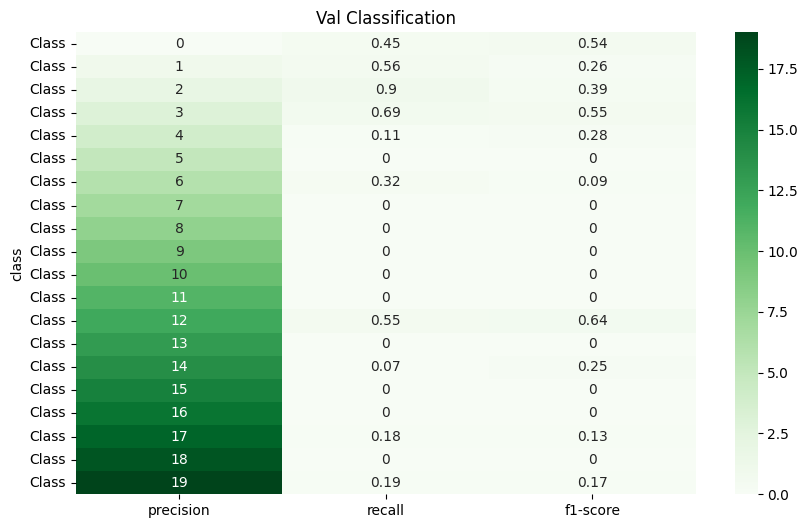

In [115]:

# Visualize the classification report
def plot_classification_report(report, title='Classification Report', cmap='Greens'):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:]:
        row_data = line.split()
        # Ensure that the row has the right number of columns and valid data
        if len(row_data) >= 5 and all(c.replace('.', '', 1).isdigit() for c in row_data[1:4]):
            try:
                row = {
                    'class': row_data[0],
                    'precision': float(row_data[1]),
                    'recall': float(row_data[2]),
                    'f1-score': float(row_data[3]),
                    'support': int(float(row_data[4]))  # Convert to float first, then to int
                }
                report_data.append(row)
            except ValueError:
                continue

    df = pd.DataFrame.from_dict(report_data)
    df.set_index('class', inplace=True)

    plt.figure(figsize=(10, 6))
    sns.heatmap(df[['precision', 'recall', 'f1-score']], annot=True, cmap=cmap)
    plt.title(title)
    plt.show()

# Plot the classification report
plot_classification_report(report_val, title='Val Classification')



# Task 5 Random Forest [20 points]

In [66]:
# TODO: Define the  Random Forest classifier and fit it on the training set (X_train, y_train)
# Hint: If using sklearn set n_jobs=-1 for parallezing the model fit


from sklearn.ensemble import RandomForestClassifier


# Initialize the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# train the Random Forest model
rf.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [96]:
# TODO: Validate on the validation data (X_test, y_test: accuracy, recall, and precision).
# Predict on validation data
y_pred_val = rf.predict(X_val)

# Get the actual classes present in the validation and test sets
actual_classes_val = np.unique(y_val)
actual_classes_test = np.unique(y_test)

# Calculate accuracy, recall, and precision on validation data
accuracy_val = accuracy_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val, average='macro', zero_division=0)
precision_val = precision_score(y_val, y_pred_val, average='macro', zero_division=0)
report_val = classification_report(y_val, y_pred_val, target_names=[f'Class {i}' for i in range(20)], labels=range(20), zero_division=0)

# Display validation results
print("Validation Accuracy:", accuracy_val)
print("Validation Recall:", recall_val)
print("Validation Precision:", precision_val)
print(report_val)

Validation Accuracy: 0.47847900390625
Validation Recall: 0.2131728768923926
Validation Precision: 0.37784683874273145
              precision    recall  f1-score   support

     Class 0       0.39      0.94      0.56     24249
     Class 1       0.70      0.20      0.31     21849
     Class 2       0.80      0.65      0.72      3891
     Class 3       0.69      0.53      0.60      8033
     Class 4       0.54      0.16      0.24      1345
     Class 5       0.02      0.01      0.01       310
     Class 6       1.00      0.02      0.03      3295
     Class 7       0.00      0.00      0.00         0
     Class 8       0.00      0.00      0.00         0
     Class 9       0.00      0.00      0.00         0
    Class 10       0.00      0.00      0.00       216
    Class 11       0.00      0.00      0.00         0
    Class 12       0.75      0.51      0.61      7582
    Class 13       0.34      0.02      0.04       970
    Class 14       0.00      0.00      0.00      3421
    Class 15     

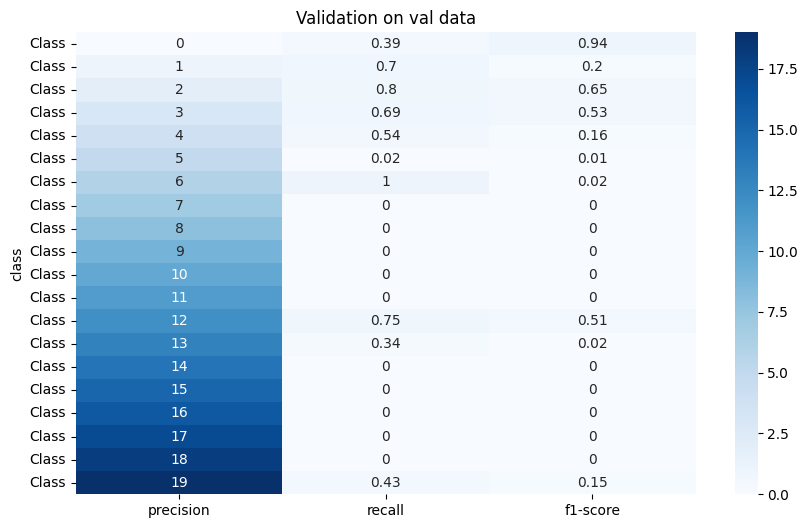

In [98]:
# Visualize the classification report
def plot_classification_report(report, title='Classification Report', cmap='Blues'):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:]:
        row_data = line.split()
        # right row and columns and valid data
        if len(row_data) >= 5 and all(c.replace('.', '', 1).isdigit() for c in row_data[1:4]):
            try:
                row = {
                    'class': row_data[0],
                    'precision': float(row_data[1]),
                    'recall': float(row_data[2]),
                    'f1-score': float(row_data[3]),
                    'support': int(float(row_data[4]))  # Convert to float first, then to int
                }
                report_data.append(row)
            except ValueError:
                continue

    df = pd.DataFrame.from_dict(report_data)
    df.set_index('class', inplace=True)

    plt.figure(figsize=(10, 6))
    sns.heatmap(df[['precision', 'recall', 'f1-score']], annot=True, cmap=cmap)
    plt.title(title)
    plt.show()

# Plot the classification report
plot_classification_report(report_val, title='Validation on val data')
